# Image Processing with Python: Enhancement for Image Differencing Applications

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### Why image sharpening is not suitable for image differencing?

In this post, we will learn how we can properly preprocess images for image differencing applications. Specifically, we will explore how sharpening an image using convolutional filters and correcting colors using histogram manipulation can affect image differencing. This article serves as an extension to my previous post about image differencing on video feeds. https://jephraim-manansala.medium.com/image-processing-with-python-image-differencing-for-video-feeds-ee071519e7d2

Let’s begin.

As usual, we import libraries such as `numpy` and `matplotlib`. We also import specific functions from the `skimage` and `scipy` library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from skimage import transform
from skimage import img_as_ubyte
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import norm, cauchy, logistic

Now', let's go back to how image differencing is done. It is done by taking the difference between two aligned and grayscale images. By doing so, we can pinpoint the changes between the two images. All static objects will be deleted, whereas all dynamic objects will have reflected on the differenced image. 

The specks of color in the differenced image depend on the difference between the intensity of the two images' pixels. The greater the intensity of the pixel (whether be it high intensity or low intensity), the more apparent the object will be on the differenced image. Note that when an object is moved from its spot, we can assume that the spot it left is the mean pixel intensity (such as the highway, railway). Thus, we wanted to maximize the difference between the high/low-intensity pixels to the mean intensity pixel. 

With this in mind, it is quite intuitive that we want to preprocess the image to accentuate the intensity of the high and low-intensity pixels to maximize its difference from the mean pixel intensity. So what image processing technique does this?

From our previous post, we have shown that image sharpening using convolutional filters can be applied to bring out detail in an image by enhancing the contrast of pixels on edges. Therefore, it can add contrast around an edge by accentuating bright and dark areas. This is exactly what we want to do, right? Let's try it!

Again, let’s use a traffic surveillance feed from a major highway in Metro Manila, Philippines.  We will use Frames #10 and #12 from the previous post. *Video courtesy of GMA News TV, Philippines).*

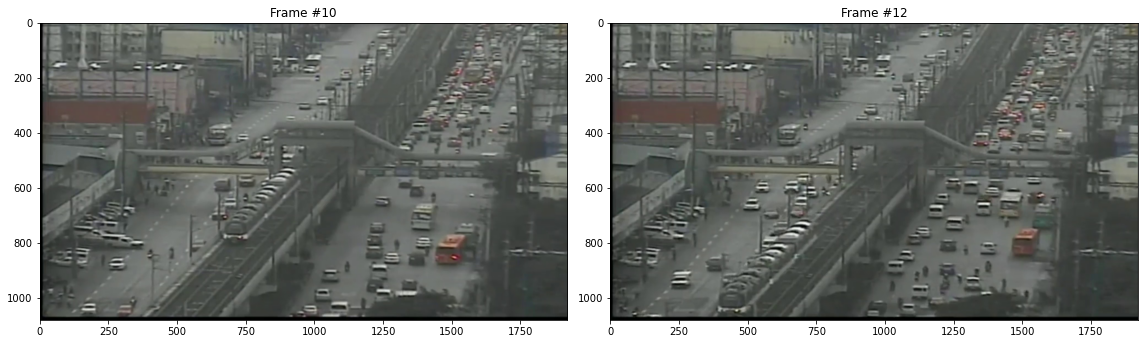

In [2]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

traffic = imread('traffic_frame10.jpg')
traffic2 = imread('traffic_frame12.jpg')
ax[0].imshow(traffic)
ax[0].set_title('Frame #10');

ax[1].imshow(traffic2)
ax[1].set_title('Frame #12');
plt.tight_layout()

Now, let's define and apply the functions needed for the sharpening convolutional filter! We can copy these functions from the ones we used in the previous post. https://medium.com/swlh/image-processing-with-python-convolutional-filters-and-kernels-b9884d91a8fd

In [3]:
def rgb_convolve2d(image, kernel):
    red = convolve2d(image[:,:,0], kernel, 'valid')
    green = convolve2d(image[:,:,1], kernel, 'valid')
    blue = convolve2d(image[:,:,2], kernel, 'valid')
    return np.stack([red, green, blue], axis=2)

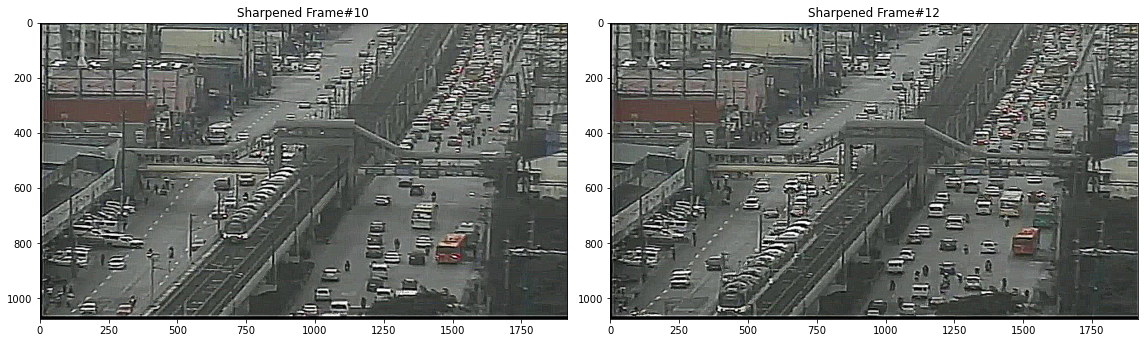

In [4]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

kernel = np.array([[-1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1],
                   [-1, -1, 25, -1, -1],
                   [-1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1]])

conv_im1 = (rgb_convolve2d(traffic, kernel[::-1, ::-1])
                          .clip(0,255)
                          .astype(np.uint8))
ax[0].imshow(conv_im1, cmap='gray')
ax[0].set_title("Sharpened Frame#10")
conv_im2 = (rgb_convolve2d(traffic2, kernel[::-1, ::-1])
                          .clip(0,255)
                          .astype(np.uint8))
ax[1].imshow(conv_im2, cmap='gray')
ax[1].set_title("Sharpened Frame#12")
plt.tight_layout()

Notice how the bright and dark spots were accentuated in the image? This only shows that the convolutional filter was effective in sharpening the image. With more exemplified bright and dark spots, we can indeed have a more effective image differencing, right? Let's find out!

Let's apply the same image processing techniques (such as homography matrix) that we did in the previous post. https://jephraim-manansala.medium.com/image-processing-with-python-image-differencing-for-video-feeds-ee071519e7d2

In [5]:
area_of_interest = [(890, 575),
                    (1085, 575),
                    (670, 1030),
                    (440, 1030)]

area_of_projection = [(930, 600),
                      (1070, 600),
                      (1070, 1000),
                      (930, 1000)]

def project_planes(image, src=area_of_interest, 
                   dst=area_of_projection):
    new_image = image.copy() 
    projection = np.zeros_like(new_image)
    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(image, tform.inverse)
    return transformed

transformed1 = project_planes(rgb2gray(conv_im1), 
                             area_of_interest, area_of_projection)
transformed2 = project_planes(rgb2gray(conv_im2), 
                             area_of_interest, area_of_projection)


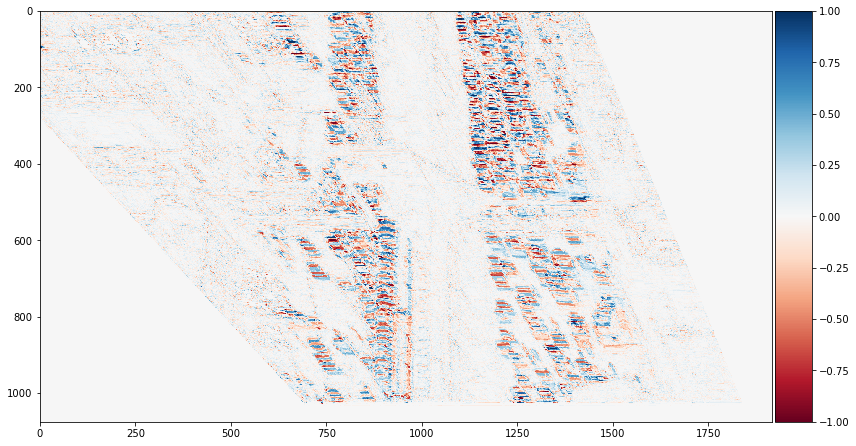

In [6]:
plt.figure(figsize=(12,12))
diff = transformed1 - transformed2
imshow(diff);

By taking the difference of the two preprocessed frames of the video feed, we can see significant changes in the differenced image. First, looking at the color bar at the side of the image, we can see that the range became -1.00 to 1.00 (from -0.65 to 0.65 in the previous post). This signifies that the sharpening convolutional filter effectively accentuates the bright and dark spots in the image. 

However, notice that the differenced image is dirtier than before? Even though the static objects did not change, there are still slight representations of these static objects on the differenced image. Moreover, even though the pixel intensity is accentuated, the noise still prevails, making it more challenging to apply the object detection algorithm in this image. This is because even though the two raw frames are almost identical, there are slight changes even on the static objects. By applying the sharpening convolutional filter on the image, we have also accentuated these slight changes. These differences might not be apparent in the resulting sharpened image. However, when we apply image differencing, these slight changes became visible as noise. 

With this finding, it is clear that we cannot use the sharpening convolutional filter to preprocess our video feeds since even though it can accentuate the bright and dark spots in the image, it can also accentuate the noise in the image.

Let's try other image preprocessing techniques - such as color correction using histogram manipulation. We are going to use the same functions that we used in my article about histogram manipulation. https://medium.com/swlh/image-processing-with-python-histogram-manipulation-on-digital-images-d4fb426d3513

In [7]:
def individual_channel(image, dist, channel):
    im_channel = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(im_channel)
    new_vals = np.interp(freq, dist.cdf(np.arange(0,256)), 
                               np.arange(0,256))
    return new_vals[im_channel].astype(np.uint8)

def distribution(image, function, mean, std):
    dist = function(mean, std)
    image_intensity = img_as_ubyte(rgb2gray(image))
    
    plt.figure(figsize=(8,6))
    freq, bins = cumulative_distribution(image_intensity)
    plt.step(bins, freq, c='b', label='Actual CDF')
    plt.plot(dist.cdf(np.arange(0,256)), 
             c='r', label='Target CDF')
    plt.legend()
    plt.title('Actual vs. Target Cumulative Distribution')

We can use different distribution functions to manipulate the histogram of the image pixel intensities by trial and error. Distribution functions like uniform, cauchy, and logistic functions can be used. Moreover, we can adjust the mean and standard deviation of these distribution functions to match the image differencing application's needs. 

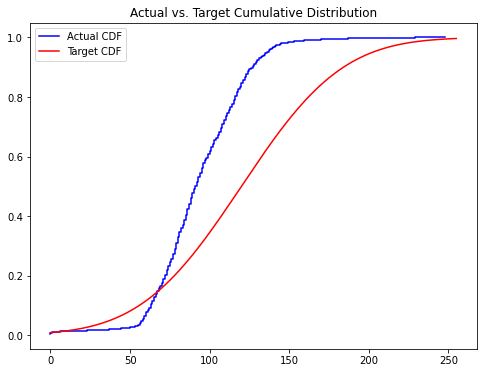

In [8]:
distribution(traffic, norm, 120, 50);

Ultimately, I have chosen a normal distribution with its mean equal to 120 and its standard deviation equal to 50. I have chosen this value because the maximum and minimum value of the CDF remains almost the same (as evident by the actual and target CDF on the top and bottom to be almost coincidental). Moreover, this accentuates the maximum and minimum pixel intensity values by reducing the pixel intensity near the maximum and minimum pixel intensity values (from 10 to 50, and 150 to 250). Finally, the distribution mean is set to 120 to ensure that the maximum-to-mean and the minimum-to-mean difference is comparable. 

In [9]:
def show_distribution(image, function, mean, std, ax, title):
    dist = function(mean, std)
    
    image_intensity = img_as_ubyte(rgb2gray(image))
    freq, bins = cumulative_distribution(image_intensity)
    
    red = individual_channel(image, dist, 0)
    green = individual_channel(image, dist, 1)
    blue = individual_channel(image, dist, 2)
    
    ax.imshow(np.dstack((red, green, blue)))
    ax.set_title(title)
    return np.dstack((red, green, blue))

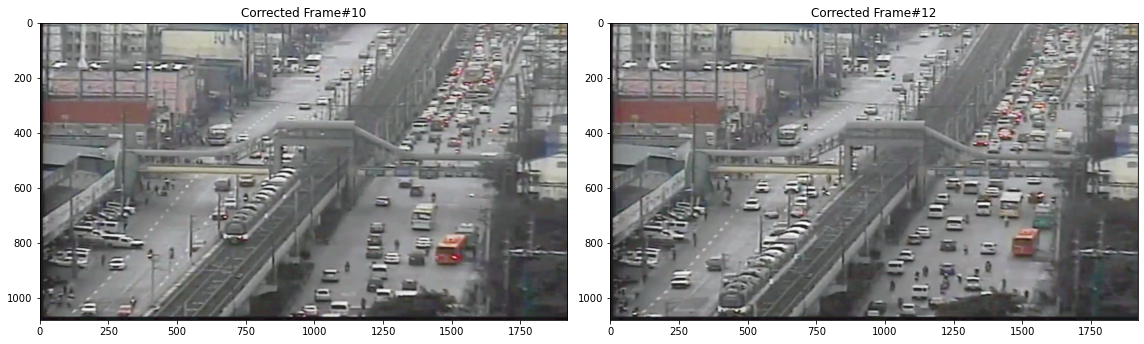

In [10]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
new = show_distribution(traffic, norm, 120, 40, 
                        ax[0], "Corrected Frame#10");
new2 = show_distribution(traffic2, norm, 120, 40, 
                         ax[1], "Corrected Frame#12");
plt.tight_layout()

By applying color correction using histogram manipulation, we have accentuated the bright and dark spots of the image while also effectively improving the image's overall color quality! Now, let's apply image differencing to these images!

In [11]:
transformed1 = project_planes(rgb2gray(new), 
                             area_of_interest, area_of_projection)
transformed2 = project_planes(rgb2gray(new2), 
                             area_of_interest, area_of_projection)

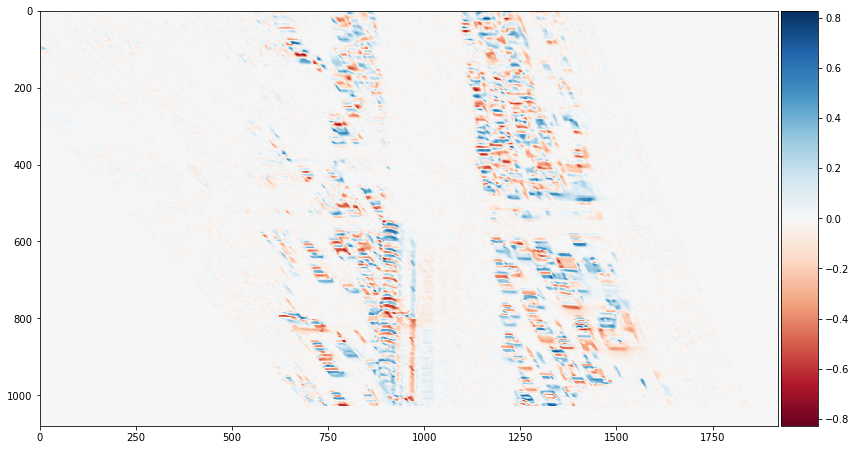

In [12]:
plt.figure(figsize=(12,12))
diff = transformed1 - transformed2
imshow(diff)

Comparing with the differenced image in the previous post, we can see that the color bar on the side of the image increased its range. The range has become -0.80 to 0.80 (from previously -0.65 to 0.65). This only shows that accentuation of the bright and dark spots is effective with histogram manipulation. Moreover, we achieved this improved intensity range while still avoiding increased noise! Amazing, right?

#### In summary

We have explored how to use the appropriate preprocessing techniques to enhance the raw images for image differencing applications. We have shown that image sharpening using convolutional filters might not be suitable because it introduces a lot of noise to the image. Color correction is deemed the best image enhancement technique because it accentuates the bright and dark areas in the image and improves the overall color quality of the image. 

Ultimately, it upon the discretion of the data scientist to know what preprocessing techniques should be used on each application. I hope you were able to pick up on the strengths and weaknesses of these image enhancement techniques! 